In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
latest_date

('2017-08-23',)

<Axes: title={'center': 'Precipitation: 8/23/16 - 8/23/17'}, xlabel='date'>

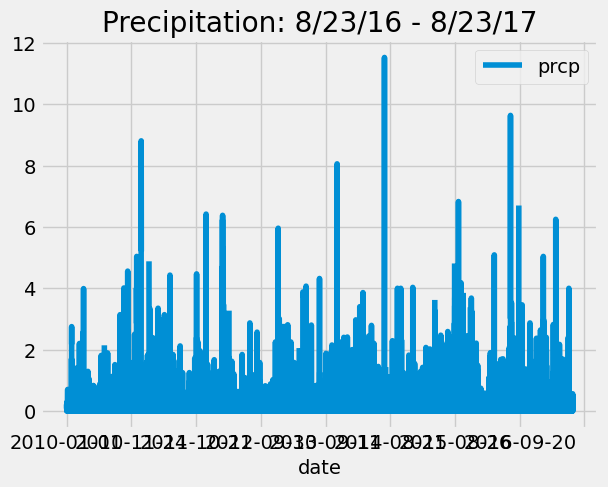

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
prcp_data = session.query(measurement.date, measurement.prcp).all()
    
# Starting from the most recent data point in the database. 
prev_year = dt.date(2017,8,23) - dt.timedelta(days=365)

#calculate one year before latest date

#convert query object to data frame and set index
rain_table = pd.DataFrame(prcp_data)
rain_table = rain_table.set_index('date')

#sort by date
rain_table = rain_table.sort_index(ascending=True)

#plot with pandas
rain_table.plot(title="Precipitation: 8/23/16 - 8/23/17")


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_table.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Station).count()
stations

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_count = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stationID = station_count[0][0]

#query for station name
station_name = (session.query(Station.name)
                      .filter_by(station = stationID))
station_name = station_name[0][0]
print(f"The most active station is {stationID}: {station_name}.")

#query for highest temperature
highest_temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highest_temp = highest_temp[0]
print(f"The highest temperature recorded there is {highest_temp} degrees Farenheit.")

#query for lowest temperature
lowest_temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowest_temp = lowest_temp[0]
print(f"The lowest temperature recorded there is {lowest_temp} degrees Farenheit.")

#query for average temperature
average_temp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
average_temp = '{0:.3}'.format(average_temp[0][0])
print(f"The average temperature recorded there is {average_temp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature recorded there is 85.0 degrees Farenheit.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


<Axes: ylabel='Frequency'>

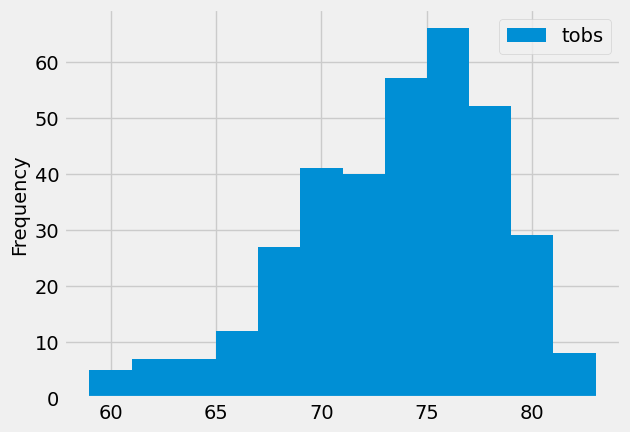

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > prev_year)
                   .filter(Measurement.station == stationID)
                   .order_by(Measurement.date)
                   .all())

#convert query object to data frame
temp_table = pd.DataFrame(temp_data)
temp_table = temp_table.set_index('date')

#sory by date
temp_table = temp_table.sort_index(ascending=True)

#histogram plot with pandas
temp_table.plot(kind='hist', bins=12)

# Close Session

In [19]:
# Close Session
session.close()